Prototypes shape: (14, 50), elements: [-1  1]
Test patterns shape: (25, 50), elements: [-1  1]


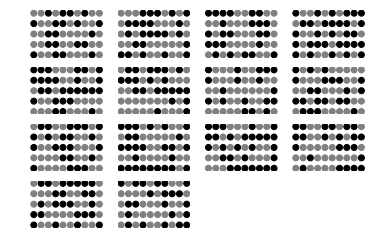

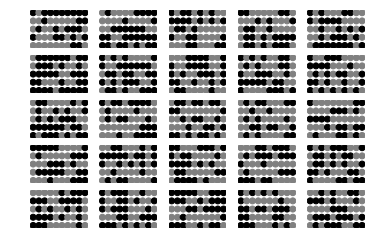

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

np.random.seed(0)
# training prototyps
prototypes = np.random.choice([-1, +1], [14, 50])
fig, axes = pyplot.subplots(4, 4)
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(prototypes):
        continue
    colors = ['gray' if prototypes[i, j] == 1 else 'black' for j in range(prototypes.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)
# testing patterns
vectors = np.random.choice([-1, +1], [25, 50])
fig, axes = pyplot.subplots(5, 5)
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(vectors):
        continue
    colors = ['gray' if vectors[i, j] == 1 else 'black' for j in range(vectors.shape[1])]
    ax.scatter(np.repeat(list(range(10)), 5), np.tile(list(range(5)), 10), c=colors)

print("Prototypes shape: {}, elements: {}".format(prototypes.shape, np.unique(prototypes)))
print("Test patterns shape: {}, elements: {}".format(vectors.shape, np.unique(vectors)))

Network capacity is roughly .14 times the number of nodes. 7 is exactly the max capacity of the network (.14 * 50 = 7)

### Hopfield network definition

In [7]:
import itertools


class HopfieldNet(object):
    def __init__(self):
        self.units = np.random.choice([-1, +1], 50)
        self.weights = np.zeros([50, 50])

    def train(self, prototypes):
        n = len(prototypes)
        print("Training with {} prototypes".format(n))
        for i, j in itertools.product(list(range(50)), list(range(50))):
            if i == j:
                self.weights[i, j] = 0  # no self-connections
                continue
            self.weights[i, j] = (1 / n) * sum(
                prototypes[u, i] * prototypes[u, j]
                # (2 * prototypes[u, i] - 1) * (2 * prototypes[u, j] - 1) 
                for u in range(n))

    def set_initial(self, pattern):
        assert len(np.unique(pattern)) == 2, pattern
        for i in range(len(pattern)):
            self.units[i] = pattern[i]

    def __call__(self, unit):
        prev_state = self.units[unit]
        if sum(self.weights[unit, j] * self.units[j]
               for j in range(len(self.units))) >= 0:
            self.units[unit] = +1
        else:
            self.units[unit] = -1
        changed = prev_state != self.units[unit]
        return changed


### Evaluation / number of blocks until convergence

Training with 1 prototypes


24
Training with 4 prototypes
24


Training with 7 prototypes


24
Training with 14 prototypes


24
{1: 156, 4: 283, 7: 285, 14: 290}
{1: [50, 50, 0, 0, 50, 50, 0, 50, 0, 0, 0, 0, 0, 0, 50, 50, 0, 50, 50, 50, 50, 0, 50, 0, 0], 4: [23, 23, 0, 25, 24, 23, 11, 12, 0, 24, 0, 12, 0, 0, 24, 23, 11, 23, 0, 0, 0, 0, 0, 12, 11], 7: [0, 22, 0, 22, 0, 23, 0, 22, 18, 23, 7, 0, 7, 0, 14, 23, 0, 18, 18, 9, 0, 0, 0, 18, 0], 14: [3, 17, 5, 5, 12, 17, 11, 12, 5, 13, 10, 10, 13, 5, 10, 9, 10, 9, 13, 10, 13, 1, 7, 10, 10]}


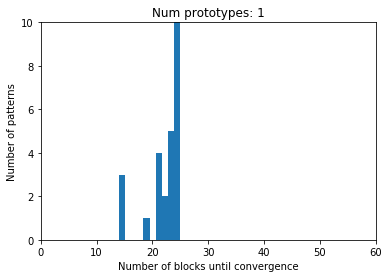

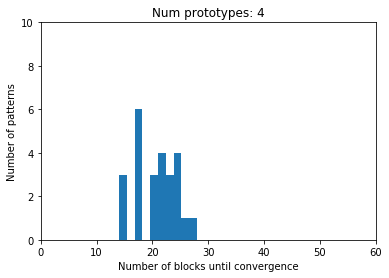

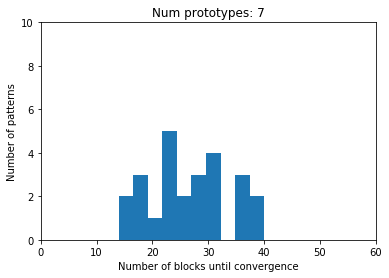

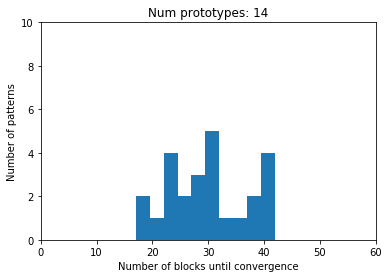

In [25]:
% matplotlib inline
from matplotlib import pyplot
import copy


def hamming_distance(state1, state2):
    assert len(state1) == len(state2)
    return sum(state1[i] != state2[i] for i in range(len(state1)))


prototype_nums = [1, 4, 7, 14]
pair_differences, prototype_distances = {}, {}
for num_prototypes in prototype_nums:
    # train network
    net = HopfieldNet()
    net.train(prototypes[:num_prototypes, :])
    # test network
    block_updates, final_states = [], []
    for pattern in range(vectors.shape[0]):
        net.set_initial(vectors[pattern, :])
        for block in itertools.count():
            units = list(range(50))
            np.random.shuffle(units)
            changed = False
            for unit in units:
                changed = changed or net(unit)
            if not changed:
                break  # done, converged
        final_states.append(copy.deepcopy(net.units))
        block_updates.append(block)

    num_pair_differences = 0
    prototype_distance = []
    for i, state in enumerate(final_states):
        min_distance = 999
        for prototype in prototypes[:num_prototypes, :]:
            assert len(prototype) == 50
            distance = hamming_distance(state, prototype)
            if distance < min_distance:  # closest prototype
                min_distance = distance
        prototype_distance.append(min_distance)
        
        for j, other_state in enumerate(final_states):
            if i > j:
                continue
            distance = hamming_distance(state, other_state)
            if i == j:
                assert distance == 0
                continue
            if distance > 0:
                num_pair_differences += 1
    pair_differences[num_prototypes] = num_pair_differences
    prototype_distances[num_prototypes] = prototype_distance

    pyplot.figure()
    pyplot.title('Num prototypes: {}'.format(num_prototypes))
    pyplot.hist(block_updates)
    pyplot.xlabel("Number of blocks until convergence")
    pyplot.ylabel("Number of patterns")
    pyplot.xlim([0, 60])
    pyplot.ylim([0, 10])
print(pair_differences)
print(prototype_distances)

The more prototypes, the longer it takes for patterns to converge.
Intuitively, this is due to more attractors pulling the states in different directions. As the number of attractors increases, the influence of each single attractor diminishes and spurious states start to occur because of all the different influences.

### Pairwise differences between final states

Text(0,0.5,'Number out of 50 final states that are pairwise different')

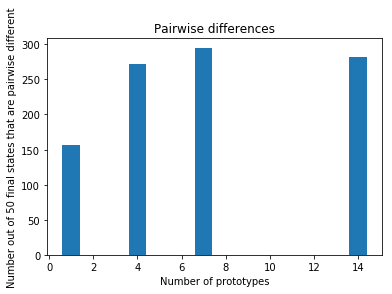

In [21]:
%matplotlib inline
pyplot.figure()
pyplot.title('Pairwise differences')
pyplot.bar(list(pair_differences.keys()), list(pair_differences.values()))
pyplot.xlabel('Number of prototypes')
pyplot.ylabel('Number out of 50 final states that are pairwise different')


(see full comment after next plots)

More prototypes means that fewer states will converge to their attractors due to spurious states. Network capacity is not enough.

### Distance to prototypes

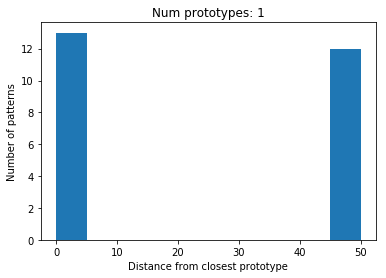

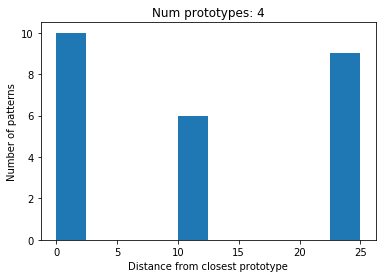

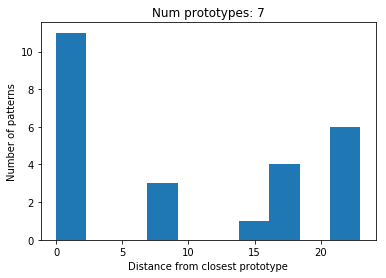

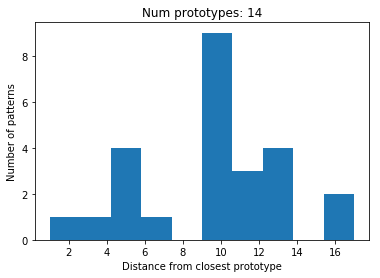

In [26]:
%matplotlib inline
for num_prototypes, distances in prototype_distances.items():
    pyplot.figure()
    pyplot.title('Num prototypes: {}'.format(num_prototypes))
    pyplot.hist(distances)
    pyplot.xlabel("Distance from closest prototype")
    pyplot.ylabel("Number of patterns")

This shows both the strengths and weaknesses of the Hopfield model:
for a single prototype, all patterns converge BUT due to the weights being mirrored, they converge to the prototype itself and the inverse prototype (all +1 --> -1 and vice-versa).
So the distance is either 0 or 50.

As the number of stored prototypes increases, things get a little easier and spurious states start to occur. The histogram thus becomes more spread out and less patterns converge to the prototypes. With more prototypes, this would become even messier (cf. Tang, Schrimpf, Lotter et al. 2017 ;-)).

I wish there was an easy way to resolve this. Hopfield networks and the whole attractor network direction sounds really promising but then there are all these small issues with them that make them unusable. Perhaps with mirror-states, there is by using symmetric weights throughout the whole network. But spurious states are the real killer, maybe using something like random bumps would help resolve this issue.

### Synchronous updates

Training with 7 prototypes
{7: 300}
{7: [18, 22, 16, 22, 21, 22, 21, 20, 18, 20, 18, 21, 14, 16, 16, 22, 18, 19, 23, 20, 20, 14, 22, 21, 18]}


Text(0,0.5,'Number of patterns')

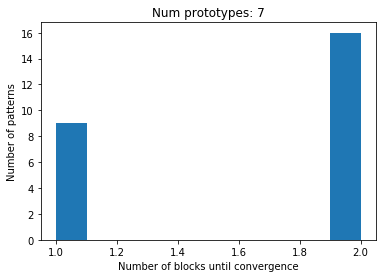

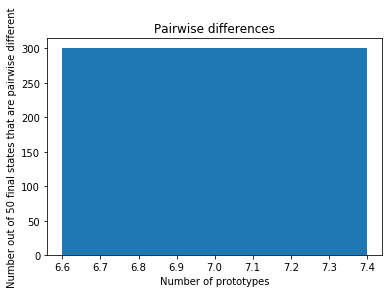

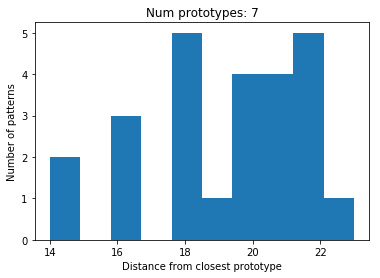

In [35]:
% matplotlib inline
from matplotlib import pyplot
import copy


class SyncHopfieldNet(HopfieldNet):
    def __call__(self):
        old_state = copy.deepcopy(self.units)
        for i in range(len(self.units)):
            if sum(self.weights[unit, j] * old_state[j]
                   for j in range(len(self.units))) >= 0:
                self.units[unit] = +1
            else:
                self.units[unit] = -1
        changed = hamming_distance(old_state, self.units) > 0
        return changed


prototype_nums = [7]
pair_differences, prototype_distances = {}, {}
for num_prototypes in prototype_nums:
    # train network
    net = SyncHopfieldNet()
    net.train(prototypes[:num_prototypes, :])
    # test network
    block_updates, final_states = [], []
    for pattern in range(vectors.shape[0]):
        net.set_initial(vectors[pattern, :])
        for block in itertools.count(start=1):
            units = list(range(50))
            np.random.shuffle(units)
            changed = net()
            if not changed:
                break  # done, converged
        final_states.append(copy.deepcopy(net.units))
        block_updates.append(block)

    num_pair_differences = 0
    prototype_distance = []
    for i, state in enumerate(final_states):
        min_distance = 999
        for prototype in prototypes[:num_prototypes, :]:
            assert len(prototype) == 50
            distance = hamming_distance(state, prototype)
            if distance < min_distance:  # closest prototype
                min_distance = distance
        prototype_distance.append(min_distance)

        for j, other_state in enumerate(final_states):
            if i > j:
                continue
            distance = hamming_distance(state, other_state)
            if i == j:
                assert distance == 0
                continue
            if distance > 0:
                num_pair_differences += 1
    pair_differences[num_prototypes] = num_pair_differences
    prototype_distances[num_prototypes] = prototype_distance

    pyplot.figure()
    pyplot.title('Num prototypes: {}'.format(num_prototypes))
    pyplot.hist(block_updates)
    pyplot.xlabel("Number of blocks until convergence")
    pyplot.ylabel("Number of patterns")
print(pair_differences)
print(prototype_distances)


pyplot.figure()
pyplot.title('Pairwise differences')
pyplot.bar(list(pair_differences.keys()), list(pair_differences.values()))
pyplot.xlabel('Number of prototypes')
pyplot.ylabel('Number out of 50 final states that are pairwise different')

pyplot.figure()
pyplot.title('Num prototypes: {}'.format(prototype_nums[0]))
pyplot.hist(prototype_distances[7])
pyplot.xlabel("Distance from closest prototype")
pyplot.ylabel("Number of patterns")


A couple of interesting things are going on here: the network converges either right away after one block or after 2 blocks, I guess the "batched" approach is more stable and converges faster. I wouldn't have expected it to be that much faster though.

The differences between final states seem to be very similar but the distance to the prototypes is a bit different in that less patterns seem to have converged to a protototype in the synchronous case. This is unexpected, I would have thought that batched processing leads to more stability also in terms of error. But perhaps it is more likely to arrive at spurious states this way.